In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append('../scripts/')
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
import keras_ocr
import tensorflow as tf
from rasterio.plot import show 
from rasterio.plot import plotting_extent
from dotenv import load_dotenv
from osdatahub import NGD

### Create Urban Mask

In [3]:
# Set API key, details from https://github.com/OrdnanceSurvey/osdatahub
load_dotenv()
key_os = os.environ['KEY']

In [4]:
ngd_collections = NGD.get_collections()
for collection in ngd_collections['collections']:
    print(f' - {collection["title"]} ({collection["id"]})')

 - Building v1 (bld-fts-building-1)
 - Building Line v1 (bld-fts-buildingline-1)
 - Building Part v1 (bld-fts-buildingpart-1)
 - Named Area v1 (gnm-fts-namedarea-1)
 - Named Point v1 (gnm-fts-namedpoint-1)
 - Land v1 (lnd-fts-land-1)
 - Landform v1 (lnd-fts-landform-1)
 - Landform Line v1 (lnd-fts-landformline-1)
 - Landform Point v1 (lnd-fts-landformpoint-1)
 - Land Point v1 (lnd-fts-landpoint-1)
 - Site v1 (lus-fts-site-1)
 - Site Access Location v1 (lus-fts-siteaccesslocation-1)
 - Site Routing Point v1 (lus-fts-siteroutingpoint-1)
 - Compound Structure v1 (str-fts-compoundstructure-1)
 - Structure v1 (str-fts-structure-1)
 - Structure Line v1 (str-fts-structureline-1)
 - Structure Point v1 (str-fts-structurepoint-1)
 - Cartographic Rail Detail v1 (trn-fts-cartographicraildetail-1)
 - Rail v1 (trn-fts-rail-1)
 - Road Line v1 (trn-fts-roadline-1)
 - Road Track Or Path v1 (trn-fts-roadtrackorpath-1)
 - Connecting Link v1 (trn-ntwk-connectinglink-1)
 - Connecting Node v1 (trn-ntwk-conn

In [5]:
# define layer for bbox extent & OS-API collection
lyr = rasterio.open("../content/tifs/1k_tifs/SK1868.tif")

# define os collections for urban mask aggreation
collections = {'buildings' : 'bld-fts-buildingpart-1',
               'sites' : 'lus-fts-site-1', 
               'railways' : 'trn-fts-rail-1', 
               'land' : 'lnd-fts-land-1',
               'water' : 'wtr-fts-waterpoint-1',
               'road' : 'trn-fts-roadline-1',
               'track' : 'trn-fts-roadtrackorpath-1',
               'waterlink' : 'wtr-ntwk-waterlink-1',
               'waterlinkset' : 'wtr-ntwk-waterlinkset-1'}

# if specifics are required from 'collection' define which to keep from 'description' column
subsets = {'Land' : ['Made Surface', 'Residential Garden', 'Non-Coniferous Trees', 'Coniferous Trees', 'Mixed Trees']}

In [30]:
from mask_os import Urban_Mask
# create object (eventually loop through 500 1k tiles here?)
SK1868 = Urban_Mask(lyr, collections, subsets)
# get the bbox of the layer
SK1868.bb()
# query the os api and return and geonadas (geopandas df)
SK1868 = SK1868.os_mask()

ngd_buildings query contains the following number of features:18
ngd_sites query contains the following number of features:1
railways query is empty!
ngd_land query contains the following number of features:129
ngd_water query contains the following number of features:1
road query is empty!
ngd_track query contains the following number of features:34
waterlink query is empty!
waterlinkset query is empty!
-- Total OS Collections Data Set Contains: 183 values
-- Final Subsetted Data Set Contains: 90 values


(Text(0.5, 58.7222222222222, 'Eastings'),
 Text(34.05379499215856, 0.5, 'Northings'))

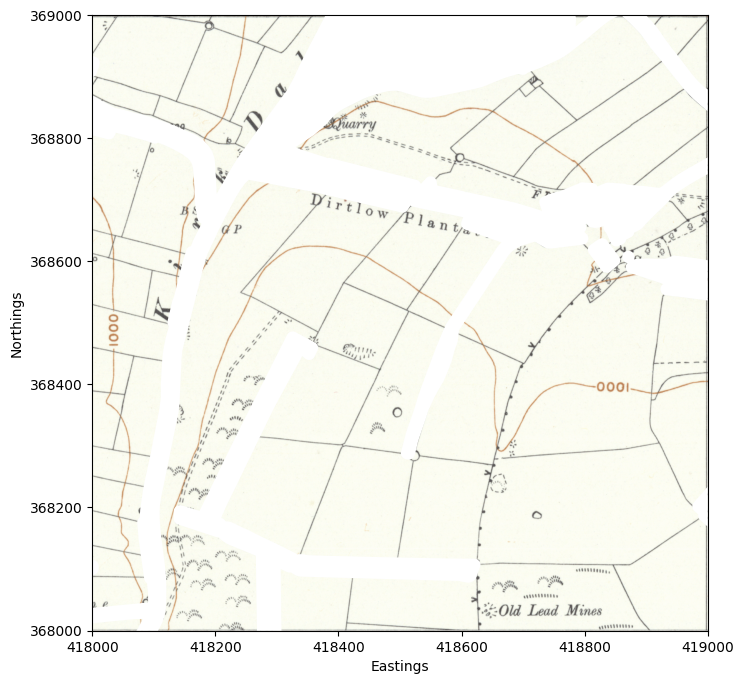

In [9]:
ax = SK1868.plot(color="white", alpha=1, figsize=(8, 8))
show(lyr, ax=ax, with_bounds=True)
ax.set_xlabel("Eastings"), ax.set_ylabel("Northings")
#ax.set_xlim(417000, xmax=419000)
#ax.set_ylim(367000, ymax=369000)

### Create Map Text Mask

In [32]:
from mask_os import Text_Mask
SK1868 = Text_Mask(lyr)

In [34]:
SK1868 = SK1868.k_mask()

Looking for C:\Users\alexad\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\alexad\.keras-ocr\crnn_kurapan.h5


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


#### Output as raster for map-reader.ipynb

In [16]:
# add a column for raster value labels
SK1868['theme'] = 1
SK1868.head()

,geometry,theme
0,"MULTIPOLYGON (((418000.330 368869.009, 418000....",1


In [17]:
# raster calcs
print(lyr.width)
print(lyr.height)
print(lyr.meta)

1490
1491
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 1490, 'height': 1491, 'count': 3, 'crs': CRS.from_epsg(27700), 'transform': Affine(0.6713639789762135, 0.0, 417999.7823474275,
       0.0, -0.6713639789762267, 369000.65026383003)}


In [29]:
import export
ex_raster = convert_shp_mask_to_raster(df_shp=SK1868,
                                           plot_raster=False,
                                           save_raster=True,
                                           verbose=1)

Current data size cube is 17.820444 MB
New cube data size is 2.24844 MB
Saved to ../content/tifs/mask.tif
